In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving transactions_full_2.csv to transactions_full_2.csv
User uploaded file "transactions_full_2.csv" with length 13772806 bytes


In [0]:
!pip install XGBoost
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import warnings
warnings.warn('ignore', category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: ignore


In [0]:
data=pd.read_csv('./transactions_full_2.csv')
data=data.rename(columns={'Unnamed: 0':'Index','CCY':'COUNTRY_CURRENCY','KYC':'AUTH_PASSED'}) 
data=data.drop(columns=['TRAN_CREATED_DATE','USER_ID','TRAN_ID','USER_CREATED_DATE','CODE','CODE3'	,'NUMCODE',	'PHONECODE',	'IS_FRAUDSTER_N'],axis=1)

data['TERMS_VERSION']=pd.to_datetime(data['TERMS_VERSION'],format='%d/%m/%Y')
data['TRANS_DAY'] = data['TERMS_VERSION'].dt.day_name()

data['TRANS_MONTH'] = data['TERMS_VERSION'].dt.month_name()
data['TRANS_YEAR'] = data['TERMS_VERSION'].dt.year
data['TRANS_YEAR']=data['TRANS_YEAR'].apply(lambda x: str(x))
data=data.drop(['TERMS_VERSION'],axis=1)
#data=data.fillna('NULL')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57748 entries, 0 to 57747
Data columns (total 25 columns):
Index                      57748 non-null int64
CURRENCY                   57748 non-null object
AMOUNT                     57748 non-null int64
TRAN_STATE                 57748 non-null object
MERCHANT_CATEGORY          20082 non-null object
MERCHANT_COUNTRY           41662 non-null object
ENTRY_METHOD               57748 non-null object
TYPE                       57748 non-null object
SOURCE                     57748 non-null object
AMOUNT_USD                 57748 non-null int64
COUNTRY_CURRENCY           57748 non-null object
EXPONENT                   57748 non-null int64
IS_CRYPTO                  57748 non-null bool
HAS_EMAIL                  55262 non-null float64
PHONE_COUNTRY              55262 non-null object
IS_FRAUDSTER               55262 non-null object
USER_STATE                 55262 non-null object
COUNTRY                    55262 non-null object
BIRTH_YEAR    

In [0]:
def change_label(label):
  if label==True:
    return 1
  elif label==False:
    return 0
  else:
    return -1
  

In [0]:
data['IS_FRAUDSTER']=data['IS_FRAUDSTER'].apply(change_label)
print ("Fraud Rate = {}".format((data[data.IS_FRAUDSTER==1].count()['IS_FRAUDSTER']/data.shape[0])*100))

Fraud Rate = 2.34813326868463


In [0]:
def inflate_fraud_rate(data):
  null_columns_list=list()
  for i in data.columns:
    if data[i].isnull().values.any()==True and data[i].dtype==object:
      null_columns_list.append(i)

  data=data.fillna("UNK")
  X_replica=[]
  pred_values=[]
  encode_list=list()
  for k in data.columns:
    if data[k].dtype==object and k!='IS_FRAUDSTER':
      
      encode_list.append(k)
      X=data[k].values.tolist()
      le = preprocessing.LabelEncoder()
      X=le.fit_transform(X)
      X_replica.append((k,le))
      data[k]=X

  for j in null_columns_list:
    if 0 in data[j].values.tolist() and j!='IS_FRAUDSTER':
   
      train_data=data[data[j]!=0]
    
    
      test_data=data[data[j]==0]   

      train_data_columns=list(train_data.columns)
      train_data_columns.remove(j)
    
      X_train=np.array(train_data[train_data_columns].values.tolist())
    
      Y_train=np.array(train_data[j].values.tolist())
      X_test=np.array(test_data[train_data_columns].values.tolist())
      Y_test=np.array(test_data[j].values.tolist())
    
      neigh = KNeighborsClassifier(n_neighbors=5)
      neigh=neigh.fit(X_train,Y_train)
      pred=neigh.predict(X_test)

      Y_train=list(Y_train)
      pred=list(pred)
    
      pred_values.append(Y_train+pred)

  for val,l in enumerate(null_columns_list):
    print (l)
    data[l]=pred_values[val]

  columns=['CURRENCY', 'AMOUNT', 'TRAN_STATE', 'MERCHANT_CATEGORY',
       'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'TYPE', 'SOURCE', 'AMOUNT_USD',
       'COUNTRY_CURRENCY', 'EXPONENT', 'IS_CRYPTO', 'HAS_EMAIL',
       'PHONE_COUNTRY',  'USER_STATE', 'COUNTRY', 'BIRTH_YEAR',
       'AUTH_PASSED', 'FAILED_SIGN_IN_ATTEMPTS', 'NAME', 'TRANS_DAY',
       'TRANS_MONTH', 'TRANS_YEAR']
    

  train_data=data[data['IS_FRAUDSTER']!=-1]
  test_data=data[data['IS_FRAUDSTER']==-1]
  X_train=np.array(train_data[columns].values.tolist())
  Y_train=np.array(train_data['IS_FRAUDSTER'].values.tolist())
  X_test=np.array(test_data[columns].values.tolist())
  Y_test=np.array(test_data['IS_FRAUDSTER'].values.tolist())

  knn=LogisticRegression(class_weight='balanced')
  knn=knn.fit(X_train,Y_train)
  pred=knn.predict(X_test)
  
  Y_train=list(Y_train)
  pred=list(pred)
  n=Y_train+pred
  data['IS_FRAUDSTER_Wt']=n
  fraud_rate=(data[data.IS_FRAUDSTER_Wt==1].count()['IS_FRAUDSTER_Wt']/data.shape[0])*100
  print (fraud_rate)

  for m in X_replica:
    col=m[0]
    obj=m[1]
    data[col]=obj.inverse_transform(data[col]) 
  data=data

  return data
    
data=inflate_fraud_rate(data)

MERCHANT_CATEGORY
MERCHANT_COUNTRY
PHONE_COUNTRY
USER_STATE
COUNTRY
AUTH_PASSED
NAME
TRANS_DAY
TRANS_MONTH


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6.614947703816583


In [0]:
#IN WHICH CURRENCY MOSTLY FRAUDULENT TRANSACTIONS OCCURRED
currency_unique_values=list(np.unique(data['CURRENCY']))
mostly_fraudulent_currency=list(data.loc[(data['IS_FRAUDSTER_Wt']==1)].CURRENCY.drop_duplicates().values)
print ("Unique Values of Currency = {}".format(currency_unique_values))
print ("Values of Fraudulent Currency = {}".format(mostly_fraudulent_currency))
new_data=data.loc[data.CURRENCY.isin(mostly_fraudulent_currency)]

##Which type merchants in transactions are flagged fradulent
mc_unique_values=list(np.unique(new_data['MERCHANT_CATEGORY']))
mostly_fraudulent_mc=list(new_data.loc[(new_data['IS_FRAUDSTER_Wt']==1)].MERCHANT_CATEGORY.drop_duplicates().values)
print ("Unique Values of MC = {}".format(mc_unique_values))
print ("Values of Fraudulent MC = {}".format(mostly_fraudulent_mc))
new_data=new_data.loc[new_data.MERCHANT_CATEGORY.isin(mostly_fraudulent_mc)]


#IN WHICH MERCHANTS Country MOSTLY FRAUDULENT TRANSACTIONS OCCURRED
mc_unique_values=list(np.unique(new_data['MERCHANT_COUNTRY']))
mostly_fraudulent_mc=list(new_data.loc[(new_data['IS_FRAUDSTER_Wt']==1)].MERCHANT_COUNTRY.drop_duplicates().values)
print ("Unique Values of MCTRY = {}".format(mc_unique_values))
print ("Values of Fraudulent MCTRY = {}".format(mostly_fraudulent_mc))
new_data=new_data.loc[new_data.MERCHANT_COUNTRY.isin(mostly_fraudulent_mc)]

##Which type of entry method in transactions are flagged fradulent
mc_unique_values=list(np.unique(new_data['ENTRY_METHOD']))
mostly_fraudulent_mc=list(new_data.loc[(new_data['IS_FRAUDSTER_Wt']==1)].ENTRY_METHOD.drop_duplicates().values)
print ("Unique Values of Entry Methods = {}".format(mc_unique_values))
print ("Values of Fraudulent Entry Methods = {}".format(mostly_fraudulent_mc))
new_data=new_data.loc[new_data.ENTRY_METHOD.isin(mostly_fraudulent_mc)]

#Which type of aources in transactions are flagged fradulent
mc_unique_values=list(np.unique(new_data['SOURCE']))
mostly_fraudulent_mc=list(new_data.loc[(new_data['IS_FRAUDSTER_Wt']==1)].SOURCE.drop_duplicates().values)
print ("Unique Values of Source = {}".format(mc_unique_values))
print ("Values of Fraudulent Sources = {}".format(mostly_fraudulent_mc))
new_data=new_data.loc[new_data.SOURCE.isin(mostly_fraudulent_mc)]

#Which type of authentications in transactions are flagged fradulent
mc_unique_values=list(np.unique(new_data['AUTH_PASSED']))
mostly_fraudulent_mc=list(new_data.loc[(new_data['IS_FRAUDSTER_Wt']==1)].AUTH_PASSED.drop_duplicates().values)
print ("Unique Values of Authentication = {}".format(mc_unique_values))
print ("Values of Fraudulent Authentication = {}".format(mostly_fraudulent_mc))
new_data=new_data.loc[new_data.AUTH_PASSED.isin(mostly_fraudulent_mc)]

new_data=new_data.drop('IS_FRAUDSTER',axis=1)

Unique Values of Currency = ['AED', 'AUD', 'BTC', 'CAD', 'CHF', 'CZK', 'DKK', 'ETH', 'EUR', 'GBP', 'HKD', 'HUF', 'ILS', 'INR', 'JPY', 'LTC', 'MAD', 'NOK', 'NZD', 'PLN', 'QAR', 'RON', 'SEK', 'SGD', 'THB', 'TRY', 'USD', 'ZAR']
Values of Fraudulent Currency = ['EUR', 'GBP', 'ZAR', 'RON', 'USD', 'INR', 'PLN', 'THB', 'CHF', 'AUD', 'CAD', 'SGD', 'SEK', 'NZD', 'ILS', 'NOK', 'ETH', 'BTC', 'HKD', 'HUF', 'MAD', 'CZK', 'DKK', 'AED']
Unique Values of MC = ['accounting', 'administrative_area_level_1', 'administrative_area_level_3', 'airport', 'amusement_park', 'aquarium', 'art_gallery', 'atm', 'bakery', 'bank', 'bar', 'beauty_salon', 'bicycle_store', 'book_store', 'bowling_alley', 'bus_station', 'cafe', 'campground', 'car_dealer', 'car_rental', 'car_repair', 'car_wash', 'casino', 'church', 'city_hall', 'clothing_store', 'convenience_store', 'courthouse', 'dentist', 'department_store', 'doctor', 'electrician', 'electronics_store', 'embassy', 'finance', 'fire_station', 'florist', 'food', 'funeral_hom

In [0]:
"""
  Weight of Evidence transformation and Information value
"""
def data_vrs(data,target,pr=True):
  
  IV_dict=dict()
  for j in data.columns:
    feature=j
    if (data[j].dtype=="object" or data[j].dtype==np.bool):
      lst=list()
      unique_values=data[feature].unique()
      for i in unique_values:
        val = i
        lst.append([feature,                                                        
                    val,
                    (data[data[feature]==val].min()[feature]),
                    (data[data[feature]==val].max()[feature]),
                    data[data[feature] == val].count()[feature],                        
                    data[(data[feature] == val) & (data[target] == 1)].count()[feature], 
                    data[(data[feature] == val) & (data[target] == 0)].count()[feature]])
        
        
      IV_table=pd.DataFrame(lst,columns=['Variable','Value','Min_Value','Max_value','Count','Fraud','Not-Fraud'])
      IV_table['Individual-Share']=IV_table['Count']/IV_table['Count'].sum()
      IV_table['Fraud-Rate-per-unique-value']=IV_table['Fraud']/IV_table['Count']
      IV_table['Not-Fraud-Rate-per-unique-value']=IV_table['Not-Fraud']/IV_table['Count']
      IV_table['Fraud-Distribution']=IV_table['Fraud']/IV_table['Fraud'].sum()
      IV_table['Not-Fraud-Distribution']=IV_table['Not-Fraud']/IV_table['Not-Fraud'].sum()
      IV_table['Weight-of-Evidence']=np.log(IV_table['Fraud-Distribution']/IV_table['Not-Fraud-Distribution'])
      IV_table=IV_table.replace({'Weight-of-Evidence':{np.inf:0.0,-np.inf:0.0}})
      IV_table['Information-Value']=(IV_table['Weight-of-Evidence'])*(IV_table['Fraud-Distribution']-IV_table['Not-Fraud-Distribution'])
      
      
      with open('my_csv.csv', 'a') as f:
        IV_table.to_csv(f,index=False, header=False)

      IV_dict[j]=IV_table['Information-Value'].sum()
    
    if (data[j].dtype==np.int64 or data[j].dtype==np.float64) and (feature!='IS_FRAUDSTER_Wt'):

      amount=pd.DataFrame(data[[feature,target]],columns=[feature,target])
      print (feature)
      bins = []
      group_names=[]
      n_bins=5

      lower_bound=int(np.min(amount[feature]))
      upper_bound=int(np.max(amount[feature]))
      step_size=upper_bound/n_bins
      i=0
      while (lower_bound<upper_bound):
        bins.append(lower_bound)
        group_names.append("bin-"+str(i+1))
        lower_bound+=step_size
        i=i+1
      group_names.pop(len(group_names)-1)
      amount['Intervals']=pd.cut(amount[feature],bins,labels=group_names)
      amount=amount.replace({'Intervals':{np.NaN:"NULL"}})
      
      #print (amount)
      lst=list()
      unique_values=amount['Intervals'].unique()
      
      for n in unique_values:
        val = n
        lst.append([feature,                                                        
                    val,
                    (amount[amount['Intervals']==val].min()['Intervals']),
                    (amount[amount['Intervals']==val].max()['Intervals']),
                    amount[amount['Intervals'] == val].count()['Intervals'],                        
                    amount[(amount['Intervals'] == val) & (amount[target] == 1)].count()['Intervals'], 
                    amount[(amount['Intervals'] == val) & (amount[target] == 0)].count()['Intervals']])
        
        
      IV_table1=pd.DataFrame(lst,columns=['Variable','Value','Min_Value','Max_value','Count','Fraud','Not-Fraud'])
      IV_table1['Individual-Share']=IV_table1['Count']/IV_table1['Count'].sum()
      IV_table1['Fraud-Rate-per-unique-value']=IV_table1['Fraud']/IV_table1['Count']
      IV_table1['Not-Fraud-Rate-per-unique-value']=IV_table1['Not-Fraud']/IV_table1['Count']
      IV_table1['Fraud-Distribution']=IV_table1['Fraud']/IV_table1['Fraud'].sum()
      IV_table1['Not-Fraud-Distribution']=IV_table1['Not-Fraud']/IV_table1['Not-Fraud'].sum()
      IV_table1['Weight-of-Evidence']=np.log(IV_table1['Fraud-Distribution']/IV_table1['Not-Fraud-Distribution'])
      IV_table1=IV_table1.replace({'Weight-of-Evidence':{np.inf:0.0,-np.inf:0.0}})
      IV_table1['Information-Value']=(IV_table1['Weight-of-Evidence'])*(IV_table1['Fraud-Distribution']-IV_table1['Not-Fraud-Distribution'])
      IV_table1=IV_table1.replace({'Information-Value':{np.inf:0.0,-np.inf:0.0}})
      with open('my_csv.csv', 'a') as f:
          IV_table1.to_csv(f,index=False, header=False)

      IV_dict[j]=IV_table1['Information-Value'].sum()
      
  return IV_dict



fl=data_vrs(new_data,'IS_FRAUDSTER_Wt',False)
      
      

Index
AMOUNT
AMOUNT_USD


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log


EXPONENT


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


In [0]:
predictor=[]
for key,value in fl.items():
  if value<=0.02:
    predictor.append((key,'useless for prediction'))
  if value>0.02 and value<=0.1:
    predictor.append((key,'Weak Predictor'))
  if value>0.1 and value<=0.3:
    predictor.append((key,'Meadium Predictor'))
  if value>0.3 and value<=0.5:
    predictor.append((key,'Strong Predictor'))
  if value>0.5:
    predictor.append((key,'Suspicious Predictor'))
    
    

In [0]:
predictor_stat=pd.DataFrame(predictor,columns=['Feature','Prediction_Decision'])
predictor_stat.head(2)

,Feature,Prediction_Decision
0,Index,Suspicious Predictor
1,CURRENCY,useless for prediction


In [0]:
IV_columns=list(predictor_stat.loc[predictor_stat.Prediction_Decision.isin(['Meadium Predictor','Strong Predictor','Suspicious Predictor'])]['Feature'])

sorted_list=sorted(fl.items(), key = lambda x : x[1], reverse=True)
sorted_list

[('Index', 1.5239461762010549),
 ('MERCHANT_CATEGORY', 0.15604425354000215),
 ('USER_STATE', 0.14028402151513325),
 ('TRANS_DAY', 0.09197142438906979),
 ('MERCHANT_COUNTRY', 0.08874718746542926),
 ('BIRTH_YEAR', 0.05016484302971207),
 ('PHONE_COUNTRY', 0.03316568851711017),
 ('COUNTRY', 0.022809177547870155),
 ('NAME', 0.02038216844942696),
 ('SOURCE', 0.020351800691499392),
 ('TRANS_MONTH', 0.015857584333890815),
 ('TYPE', 0.0150588465988823),
 ('CURRENCY', 0.014335916602498732),
 ('COUNTRY_CURRENCY', 0.014335916602498732),
 ('ENTRY_METHOD', 0.012344935494327832),
 ('AUTH_PASSED', 0.0071044799426767755),
 ('TRAN_STATE', 0.006737182995782104),
 ('FAILED_SIGN_IN_ATTEMPTS', 0.0038584237576817617),
 ('TRANS_YEAR', 0.0018973805506949815),
 ('IS_CRYPTO', 0.0015129301423951879),
 ('AMOUNT_USD', 0.0011029084088578947),
 ('HAS_EMAIL', 0.0010291716916264867),
 ('AMOUNT', 0.000803587951833426),
 ('EXPONENT', 0.0)]

In [0]:
woe_columns=['Variable','Value','Min_Value','Max_value','Count','Fraud','Not-Fraud',
             'Individual-Share','Fraud-Rate-per-unique-value','Not-Fraud-Rate-per-unique-value',
             'Fraud-Distribution','Not-Fraud-Distribution','Weight-of-Evidence','Information-Value']
woe_table=pd.read_csv('./my_csv.csv',names=woe_columns)
woe_table.head(5)

In [0]:
def prepare_dataset(data,columns,target):
  #Encode dataset
  for i in columns:
    if data[i].dtype==object:
      X=data[i].values.tolist()
      le = preprocessing.LabelEncoder()
      X=le.fit_transform(X)
      data[i]=X
  X=data[columns].values.tolist()
  #data[target]=data[target].apply(lambda x: 1 if x==True else 0)
  Y=data[target].values.tolist()
  X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.30,random_state=5)
  return X_train,X_test,Y_train,Y_test,X,Y

In [0]:
def BM_LR_Model(X_train,X_test,Y_train,Y_test,cw="LR"):
  if cw=="LR":
    clf = LogisticRegression(random_state=42,solver='lbfgs',multi_class='ovr',max_iter=1000).fit(X_train, Y_train)
    pred=clf.predict(X_test)

    filename='Fraud_Detection_LR.pkl'
    joblib.dump(clf,filename)
    return pred
  if cw=="XG":
      clf = XGBClassifier().fit(X_train, Y_train)
      pred=clf.predict(X_test)
      #print (pred)
      #pred = [round(value) for value in pred]

      filename='Fraud_Detection_XG_BOOST.pkl'
      joblib.dump(clf,filename)
      return pred
    
  if cw=="RF":
    RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=50).fit(X_train, Y_train)
    pred=clf.predict(X_test)
    

    filename='Fraud_Detection_RF.pkl'
    joblib.dump(clf,filename)
    return pred

In [0]:
def performance_metrics(pred,Y_test):
    score=precision_score(Y_test,pred,average='weighted')*100
    F1_Score=f1_score(Y_test,pred,average='weighted')*100
    accuracy=(np.sum(Y_test==pred)/len(Y_test))*100
    recall=recall_score(Y_test,pred,average='weighted')*100
    auc=roc_auc_score(Y_test,pred)*100
    
    return score,F1_Score,accuracy,recall,auc
    

In [0]:
classifiers=['LR','XG','RF']
result_table=pd.DataFrame(columns=['Model','F1-Score','Accuracy','Precision','Recall','Area_Under_Curve','fpr','tpr','Actual_Values','Pred_Values'])

In [0]:

for i in classifiers:
  X_train,X_test,Y_train,Y_test,X,Y=prepare_dataset(new_data,IV_columns,'IS_FRAUDSTER_Wt')

  pred= BM_LR_Model(np.array(X_train),np.array(X_test),np.array(Y_train),np.array(Y_test),i)
  precision,F1_Score,accuracy,recall,auc=performance_metrics(pred,Y_test)
  fpr,tpr,_=roc_curve(Y_test,pred)
  result_table=result_table.append({'Model':i,'F1-Score':F1_Score,'Accuracy':accuracy,'Precision':precision,'Recall':recall,'Area_Under_Curve':auc,'fpr':fpr,'tpr':tpr,'Actual_Values':Y_test,'Pred_Values':pred}
                      ,ignore_index=True)

  
result_table.set_index('Model',inplace=True)  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
result_table

,F1-Score,Accuracy,Precision,Recall,Area_Under_Curve,fpr,tpr,Actual_Values,Pred_Values
Model,,,,,,,,,
LR,89.978117,93.239916,86.936819,93.239916,50.000000,"[0.0, 1.0]","[0.0, 1.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
XG,97.376047,97.607880,97.643415,97.607880,82.588573,"[0.0, 0.0004401685216625794, 1.0]","[0.0, 0.6522116218560278, 1.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
RF,95.658397,95.684803,95.633742,95.684803,82.281300,"[0.0, 0.022197069735270074, 1.0]","[0.0, 0.6678230702515178, 1.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


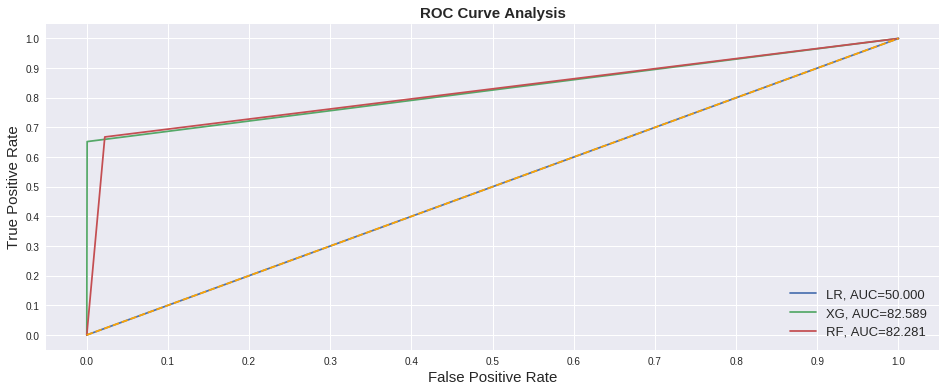

In [0]:
fig = plt.figure(figsize=(16,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['Area_Under_Curve']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()